## Step 1: load data

In [1]:
%load_ext autoreload
%autoreload 2

from utils import *
from dual import *

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
def data_prep(data):
    data_size = len(data.index)

    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # code categories to -1/1
    gender_encoder = LabelEncoder()
    y = np.array(gender_encoder.fit_transform(y))
    y = y * 2 - 1

    # normalize data
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.fit(X)
    X = np.array(scaler.transform(X))
    
    return X, y

In [3]:
from sklearn import svm
from sklearn.model_selection import train_test_split
voice_shuffle = load_file('voice_numsamp_shuffle_full')

In [4]:
voice_shuffle.shape

(3168, 21)

In [5]:
X_full, y_full = data_prep(voice_shuffle)
X_full = X_full[:,:8]
X, X_test, y, y_test = train_test_split(X_full, y_full, train_size=500, random_state=42)

## step 2: get normal SVM models

In [145]:
# generate models

C_vals = np.logspace(-3, 3, 100)
models = list()

for index, cval in enumerate(C_vals):
    print(index,end='/')
    models.append(svm.SVC(kernel='linear', C=cval, probability=False))
    models[index].fit(X, y)

#save_file('models_voice_500_8_-3_1_10',models)

0/1/2/3/4/5/6/7/8/9/10/11/12/13/14/15/16/17/18/19/20/21/22/23/24/25/26/27/28/29/30/31/32/33/34/35/36/37/38/39/40/41/42/43/44/45/46/47/48/49/50/51/52/53/54/55/56/57/58/59/60/61/62/63/64/65/66/67/68/69/70/71/72/73/74/75/76/77/78/79/80/81/82/83/84/85/86/87/88/89/90/91/92/93/94/95/96/97/98/99/

In [6]:
# Load models from file


C_vals = np.logspace(-3, 1, 10)
models = load_file('models_voice_500_8_-3_1_10')

In [7]:
msizes=[]
bounds=[]
risks=[]
emp_risks=[]
for model in models:
    w = np.array(model.coef_[0])
    margin_size = 1 / np.sqrt(np.sum(w ** 2))
    
    C = model.get_params()['C']
    emp_risk = (y != model.predict(X)).sum()/X.shape[0]
    risk = (y_test != model.predict(X_test)).sum()/X_test.shape[0]
    
    risks.append(risk)
    emp_risks.append(emp_risk)
    
    print(C, margin_size, model.intercept_[0], emp_risk, risk, sep='\t')
    msizes.append(margin_size)
    bounds.append(np.abs(model.intercept_[0]))

0.001	6.300349112375079	-0.7508321989085531	0.468	0.5059970014992504
0.0027825594022071257	2.2642905636812913	-0.30785846155887747	0.478	0.5052473763118441
0.007742636826811269	0.9960703593461656	0.35691545781210654	0.188	0.18403298350824587
0.021544346900318832	0.5995314150306045	0.5891705546820362	0.11	0.11356821589205397
0.05994842503189409	0.4423364915321251	0.5466700113839728	0.108	0.1090704647676162
0.1668100537200059	0.35237192423144303	0.5315693430460212	0.096	0.10569715142428786
0.46415888336127775	0.29448722943071404	0.5134454248175655	0.09	0.10644677661169415
1.2915496650148828	0.2451668365057354	0.6638050670076462	0.092	0.106071964017991
3.593813663804626	0.22126671604713766	0.7649561885261154	0.094	0.10457271364317841
10.0	0.19326322646266716	0.9103384999835901	0.092	0.10532233883058471


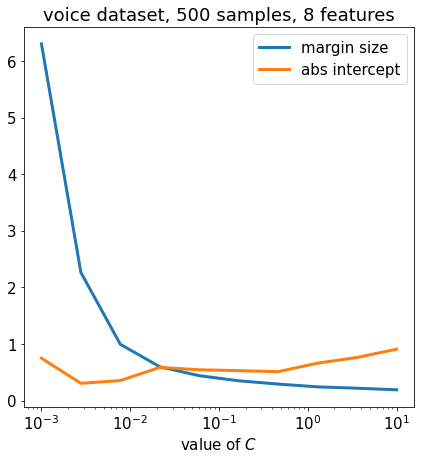

In [8]:
plt.figure(figsize=(7,7))
plt.rcParams.update({'font.size': 15})
plt.xscale('log')
plt.xlabel(r'value of $C$')

plt.plot(C_vals, msizes, label="margin size", lw=3)
plt.plot(C_vals, bounds, label="abs intercept", lw=3)
plt.legend()
plt.title("voice dataset, 500 samples, 8 features")

plt.savefig("images/v_margin-vs-c1.png")

plt.show()

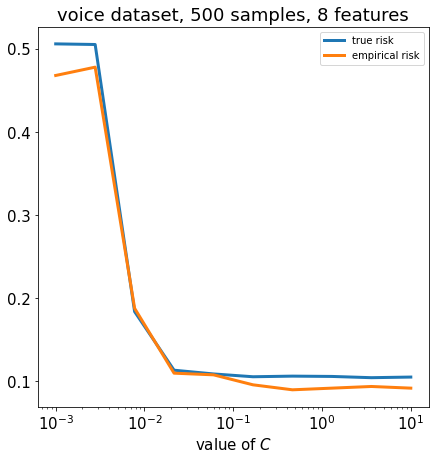

In [9]:
plt.figure(figsize=(7,7))
plt.xscale('log')
plt.xlabel(r'value of $C$')

plt.plot(C_vals, risks, label="true risk", lw=3)
plt.plot(C_vals, emp_risks, label="empirical risk", lw=3)
plt.legend(fontsize=10)

plt.title("voice dataset, 500 samples, 8 features")
plt.savefig("images/v_margin-vs-c2.png")


In [10]:
models

[SVC(C=0.001, kernel='linear'),
 SVC(C=0.0027825594022071257, kernel='linear'),
 SVC(C=0.007742636826811269, kernel='linear'),
 SVC(C=0.021544346900318832, kernel='linear'),
 SVC(C=0.05994842503189409, kernel='linear'),
 SVC(C=0.1668100537200059, kernel='linear'),
 SVC(C=0.46415888336127775, kernel='linear'),
 SVC(C=1.2915496650148828, kernel='linear'),
 SVC(C=3.593813663804626, kernel='linear'),
 SVC(C=10.0, kernel='linear')]

## step 3: calc rademacher of confidence

In [10]:
folder_name = "final_voice500_8_-3_1_10"

In [11]:
runs_per_sample = 10
maxiter = 100
init_temp = 5500
accept = -5

pump_cycles = 1000

m = X.shape[0]
m

500

In [21]:
for pc in range(pump_cycles):

    for index, model in enumerate(models):
        
        print('\n', index, ':', pc, '///', end=' ')
        
        # sample X and Y sets of size m from the whole set
        
        PUMP_X = pd.DataFrame(X_full).sample(m, replace=False)
        PUMP_Y = y_full[PUMP_X.index]
        
        # get margin size and bound on intercept
        
        w = np.array(model.coef_[0])
        mar = 1 / np.sqrt(np.sum(w ** 2))
        b = np.abs(model.intercept_[0])
        
        
        
        # generate rademacher vector
        radvec = [rd.randint(0, 1) * 2 - 1 for x in range(m)]
        
        #################
        ## Calculate Confidence Rademacher Complexity
        print('conf', end=' ')
        
        DATA_SAVE_NAME = 'histories/'+folder_name+'/'+str(index)+'_Rconfidence'

        try:
            history1 = load_file(DATA_SAVE_NAME)
        except:
            print('new file')
            history1 = RDhistory('confidence')

        pump_rademacher(PUMP_X, PUMP_Y,
                        history=history1,
                        radvec=radvec,
                        runs_per_sample=1,
                        margin=1.0, bound=b,
                        verbose=False)

        save_file(DATA_SAVE_NAME, history1)
        
        
        #################
        ## Calculate Margin loss Rademacher Complexity
        print('mloss', end=' ')
        
        DATA_SAVE_NAME = 'histories/'+folder_name+'/'+str(index)+'_Rmarginloss'

        try:
            history2 = load_file(DATA_SAVE_NAME)
        except:
            print('new file', end=' ')
            history2 = RDhistory('margin_loss')

        pump_rademacher(PUMP_X, PUMP_Y,
                        history=history2,
                        radvec=radvec,
                        runs_per_sample=runs_per_sample,
                        margin=mar, bound=b,
                        verbose=False,
                        method='da', kwargs={'maxiter':maxiter, 'initial_temp':init_temp, 'accept':accept})

        save_file(DATA_SAVE_NAME, history2)
        
        #################
        ## Calculate Outlier Func
        print('out', end=' ')
        
        DATA_SAVE_NAME = 'histories/'+folder_name+'/'+str(index)+'_Outlier'

        try:
            history3 = load_file(DATA_SAVE_NAME)
        except:
            print('creating new file')
            history3 = list()

        res = solve_outlier(X_full, y_full, PUMP_X, PUMP_Y, mar, b,
                kwargs={'maxiter':maxiter, 'initial_temp':init_temp, 'accept':accept})
        history3.append(-res.fun)

        save_file(DATA_SAVE_NAME, history3)
        
        


 0 : 0 /// conf mloss out 
 1 : 0 /// conf mloss out 
 2 : 0 /// conf mloss out 
 3 : 0 /// conf mloss out 
 4 : 0 /// conf mloss out 
 5 : 0 /// conf mloss out 
 6 : 0 /// conf mloss out 
 7 : 0 /// conf mloss out 
 8 : 0 /// conf mloss out 
 9 : 0 /// conf mloss out 
 0 : 1 /// conf mloss out 
 1 : 1 /// conf mloss out 
 2 : 1 /// conf mloss out 
 3 : 1 /// conf mloss out 
 4 : 1 /// conf mloss out 
 5 : 1 /// conf mloss out 
 6 : 1 /// conf mloss out 
 7 : 1 /// conf mloss out 
 8 : 1 /// conf mloss out 
 9 : 1 /// conf mloss out 
 0 : 2 /// conf mloss out 
 1 : 2 /// conf mloss out 
 2 : 2 /// conf mloss out 
 3 : 2 /// conf mloss out 
 4 : 2 /// conf mloss out 
 5 : 2 /// conf mloss out 
 6 : 2 /// conf mloss out 
 7 : 2 /// conf mloss out 
 8 : 2 /// conf mloss out 
 9 : 2 /// conf mloss out 
 0 : 3 /// conf mloss out 
 1 : 3 /// conf mloss out 
 2 : 3 /// conf mloss out 
 3 : 3 /// conf mloss out 
 4 : 3 /// conf mloss out 
 5 : 3 /// conf mloss out 
 6 : 3 /// conf mloss out 


 8 : 58 /// conf mloss out 
 9 : 58 /// conf mloss out 
 0 : 59 /// conf mloss out 
 1 : 59 /// conf mloss out 
 2 : 59 /// conf mloss out 
 3 : 59 /// conf mloss out 
 4 : 59 /// conf mloss out 
 5 : 59 /// conf mloss out 
 6 : 59 /// conf mloss out 
 7 : 59 /// conf mloss out 
 8 : 59 /// conf mloss out 
 9 : 59 /// conf mloss out 
 0 : 60 /// conf mloss out 
 1 : 60 /// conf mloss out 
 2 : 60 /// conf mloss out 
 3 : 60 /// conf mloss out 
 4 : 60 /// conf mloss out 
 5 : 60 /// conf mloss out 
 6 : 60 /// conf mloss out 
 7 : 60 /// conf mloss out 
 8 : 60 /// conf mloss out 
 9 : 60 /// conf mloss out 
 0 : 61 /// conf mloss out 
 1 : 61 /// conf mloss out 
 2 : 61 /// conf mloss out 
 3 : 61 /// conf mloss out 
 4 : 61 /// conf mloss out 
 5 : 61 /// conf mloss out 
 6 : 61 /// conf mloss out 
 7 : 61 /// conf mloss out 
 8 : 61 /// conf mloss out 
 9 : 61 /// conf mloss out 
 0 : 62 /// conf mloss out 
 1 : 62 /// conf mloss out 
 2 : 62 /// conf mloss out 
 3 : 62 /// conf mlo

 6 : 116 /// conf mloss out 
 7 : 116 /// conf mloss out 
 8 : 116 /// conf mloss out 
 9 : 116 /// conf mloss out 
 0 : 117 /// conf mloss out 
 1 : 117 /// conf mloss out 
 2 : 117 /// conf mloss out 
 3 : 117 /// conf mloss out 
 4 : 117 /// conf mloss out 
 5 : 117 /// conf mloss out 
 6 : 117 /// conf mloss out 
 7 : 117 /// conf mloss out 
 8 : 117 /// conf mloss out 
 9 : 117 /// conf mloss out 
 0 : 118 /// conf mloss out 
 1 : 118 /// conf mloss out 
 2 : 118 /// conf mloss out 
 3 : 118 /// conf mloss out 
 4 : 118 /// conf mloss out 
 5 : 118 /// conf mloss out 
 6 : 118 /// conf mloss out 
 7 : 118 /// conf mloss out 
 8 : 118 /// conf mloss out 
 9 : 118 /// conf mloss out 
 0 : 119 /// conf mloss out 
 1 : 119 /// conf mloss out 
 2 : 119 /// conf mloss out 
 3 : 119 /// conf mloss out 
 4 : 119 /// conf mloss out 
 5 : 119 /// conf mloss out 
 6 : 119 /// conf mloss out 
 7 : 119 /// conf mloss out 
 8 : 119 /// conf mloss out 
 9 : 119 /// conf mloss out 
 0 : 120 /// c

 0 : 173 /// conf mloss out 
 1 : 173 /// conf mloss out 
 2 : 173 /// conf mloss out 
 3 : 173 /// conf mloss out 
 4 : 173 /// conf mloss out 
 5 : 173 /// conf mloss out 
 6 : 173 /// conf mloss out 
 7 : 173 /// conf mloss out 
 8 : 173 /// conf mloss out 
 9 : 173 /// conf mloss out 
 0 : 174 /// conf mloss out 
 1 : 174 /// conf mloss out 
 2 : 174 /// conf mloss out 
 3 : 174 /// conf mloss out 
 4 : 174 /// conf mloss out 
 5 : 174 /// conf mloss out 
 6 : 174 /// conf mloss out 
 7 : 174 /// conf mloss out 
 8 : 174 /// conf mloss out 
 9 : 174 /// conf mloss out 
 0 : 175 /// conf mloss out 
 1 : 175 /// conf mloss out 
 2 : 175 /// conf mloss out 
 3 : 175 /// conf mloss out 
 4 : 175 /// conf mloss out 
 5 : 175 /// conf mloss out 
 6 : 175 /// conf mloss out 
 7 : 175 /// conf mloss out 
 8 : 175 /// conf mloss out 
 9 : 175 /// conf mloss out 
 0 : 176 /// conf mloss out 
 1 : 176 /// conf mloss out 
 2 : 176 /// conf mloss out 
 3 : 176 /// conf mloss out 
 4 : 176 /// c

 4 : 229 /// conf mloss out 
 5 : 229 /// conf mloss out 
 6 : 229 /// conf mloss out 
 7 : 229 /// conf mloss out 
 8 : 229 /// conf mloss out 
 9 : 229 /// conf mloss out 
 0 : 230 /// conf mloss out 
 1 : 230 /// conf mloss out 
 2 : 230 /// conf mloss out 
 3 : 230 /// conf mloss out 
 4 : 230 /// conf mloss out 
 5 : 230 /// conf mloss out 
 6 : 230 /// conf mloss out 
 7 : 230 /// conf mloss out 
 8 : 230 /// conf mloss out 
 9 : 230 /// conf mloss out 
 0 : 231 /// conf mloss out 
 1 : 231 /// conf mloss out 
 2 : 231 /// conf mloss out 
 3 : 231 /// conf mloss out 
 4 : 231 /// conf mloss out 
 5 : 231 /// conf mloss out 
 6 : 231 /// conf mloss out 
 7 : 231 /// conf mloss out 
 8 : 231 /// conf mloss out 
 9 : 231 /// conf mloss out 
 0 : 232 /// conf mloss out 
 1 : 232 /// conf mloss out 
 2 : 232 /// conf mloss out 
 3 : 232 /// conf mloss out 
 4 : 232 /// conf mloss out 
 5 : 232 /// conf mloss out 
 6 : 232 /// conf mloss out 
 7 : 232 /// conf mloss out 
 8 : 232 /// c

 8 : 285 /// conf mloss out 
 9 : 285 /// conf mloss out 
 0 : 286 /// conf mloss out 
 1 : 286 /// conf mloss out 
 2 : 286 /// conf mloss out 
 3 : 286 /// conf mloss out 
 4 : 286 /// conf mloss out 
 5 : 286 /// conf mloss out 
 6 : 286 /// conf mloss out 
 7 : 286 /// conf mloss out 
 8 : 286 /// conf mloss out 
 9 : 286 /// conf mloss out 
 0 : 287 /// conf mloss out 
 1 : 287 /// conf mloss out 
 2 : 287 /// conf mloss out 
 3 : 287 /// conf mloss out 
 4 : 287 /// conf mloss out 
 5 : 287 /// conf mloss out 
 6 : 287 /// conf mloss out 
 7 : 287 /// conf mloss out 
 8 : 287 /// conf mloss out 
 9 : 287 /// conf mloss out 
 0 : 288 /// conf mloss out 
 1 : 288 /// conf mloss out 
 2 : 288 /// conf mloss out 
 3 : 288 /// conf mloss out 
 4 : 288 /// conf mloss out 
 5 : 288 /// conf mloss out 
 6 : 288 /// conf mloss out 
 7 : 288 /// conf mloss out 
 8 : 288 /// conf mloss out 
 9 : 288 /// conf mloss out 
 0 : 289 /// conf mloss out 
 1 : 289 /// conf mloss out 
 2 : 289 /// c

 2 : 342 /// conf mloss out 
 3 : 342 /// conf mloss out 
 4 : 342 /// conf mloss out 
 5 : 342 /// conf mloss out 
 6 : 342 /// conf mloss out 
 7 : 342 /// conf mloss out 
 8 : 342 /// conf mloss out 
 9 : 342 /// conf mloss out 
 0 : 343 /// conf mloss out 
 1 : 343 /// conf mloss out 
 2 : 343 /// conf mloss out 
 3 : 343 /// conf mloss out 
 4 : 343 /// conf mloss out 
 5 : 343 /// conf mloss out 
 6 : 343 /// conf mloss out 
 7 : 343 /// conf mloss out 
 8 : 343 /// conf mloss out 
 9 : 343 /// conf mloss out 
 0 : 344 /// conf mloss out 
 1 : 344 /// conf mloss out 
 2 : 344 /// conf mloss out 
 3 : 344 /// conf mloss out 
 4 : 344 /// conf mloss out 
 5 : 344 /// conf mloss out 
 6 : 344 /// conf mloss out 
 7 : 344 /// conf mloss out 
 8 : 344 /// conf mloss out 
 9 : 344 /// conf mloss out 
 0 : 345 /// conf mloss out 
 1 : 345 /// conf mloss out 
 2 : 345 /// conf mloss out 
 3 : 345 /// conf mloss out 
 4 : 345 /// conf mloss out 
 5 : 345 /// conf mloss out 
 6 : 345 /// c

 6 : 398 /// conf mloss out 
 7 : 398 /// conf mloss out 
 8 : 398 /// conf mloss out 
 9 : 398 /// conf mloss out 
 0 : 399 /// conf mloss out 
 1 : 399 /// conf mloss out 
 2 : 399 /// conf mloss out 
 3 : 399 /// conf mloss out 
 4 : 399 /// conf mloss out 
 5 : 399 /// conf mloss out 
 6 : 399 /// conf mloss out 
 7 : 399 /// conf mloss out 
 8 : 399 /// conf mloss out 
 9 : 399 /// conf mloss out 
 0 : 400 /// conf mloss out 
 1 : 400 /// conf mloss out 
 2 : 400 /// conf mloss out 
 3 : 400 /// conf mloss out 
 4 : 400 /// conf mloss out 
 5 : 400 /// conf mloss out 
 6 : 400 /// conf mloss out 
 7 : 400 /// conf mloss out 
 8 : 400 /// conf mloss out 
 9 : 400 /// conf mloss out 
 0 : 401 /// conf mloss out 
 1 : 401 /// conf mloss out 
 2 : 401 /// conf mloss out 
 3 : 401 /// conf mloss out 
 4 : 401 /// conf mloss out 
 5 : 401 /// conf mloss out 
 6 : 401 /// conf mloss out 
 7 : 401 /// conf mloss out 
 8 : 401 /// conf mloss out 
 9 : 401 /// conf mloss out 
 0 : 402 /// c

 0 : 455 /// conf mloss out 
 1 : 455 /// conf mloss out 
 2 : 455 /// conf mloss out 
 3 : 455 /// conf mloss out 
 4 : 455 /// conf mloss out 
 5 : 455 /// conf mloss out 
 6 : 455 /// conf mloss out 
 7 : 455 /// conf mloss out 
 8 : 455 /// conf mloss out 
 9 : 455 /// conf mloss out 
 0 : 456 /// conf mloss out 
 1 : 456 /// conf mloss out 
 2 : 456 /// conf mloss out 
 3 : 456 /// conf mloss out 
 4 : 456 /// conf mloss out 
 5 : 456 /// conf mloss out 
 6 : 456 /// conf mloss out 
 7 : 456 /// conf mloss out 
 8 : 456 /// conf mloss out 
 9 : 456 /// conf mloss out 
 0 : 457 /// conf mloss out 
 1 : 457 /// conf mloss out 
 2 : 457 /// conf mloss out 
 3 : 457 /// conf mloss out 
 4 : 457 /// conf mloss out 
 5 : 457 /// conf mloss out 
 6 : 457 /// conf mloss out 
 7 : 457 /// conf mloss out 
 8 : 457 /// conf mloss out 
 9 : 457 /// conf mloss out 
 0 : 458 /// conf mloss out 
 1 : 458 /// conf mloss out 
 2 : 458 /// conf mloss out 
 3 : 458 /// conf mloss out 
 4 : 458 /// c

 4 : 511 /// conf mloss out 
 5 : 511 /// conf mloss out 
 6 : 511 /// conf mloss out 
 7 : 511 /// conf mloss out 
 8 : 511 /// conf mloss out 
 9 : 511 /// conf mloss out 
 0 : 512 /// conf mloss out 
 1 : 512 /// conf mloss out 
 2 : 512 /// conf mloss out 
 3 : 512 /// conf mloss out 
 4 : 512 /// conf mloss out 
 5 : 512 /// conf mloss out 
 6 : 512 /// conf mloss out 
 7 : 512 /// conf mloss out 
 8 : 512 /// conf mloss out 
 9 : 512 /// conf mloss out 
 0 : 513 /// conf mloss out 
 1 : 513 /// conf mloss out 
 2 : 513 /// conf mloss out 
 3 : 513 /// conf mloss out 
 4 : 513 /// conf mloss out 
 5 : 513 /// conf mloss out 
 6 : 513 /// conf mloss out 
 7 : 513 /// conf mloss out 
 8 : 513 /// conf mloss out 
 9 : 513 /// conf mloss out 
 0 : 514 /// conf mloss out 
 1 : 514 /// conf mloss out 
 2 : 514 /// conf mloss out 
 3 : 514 /// conf mloss out 
 4 : 514 /// conf mloss out 
 5 : 514 /// conf mloss out 
 6 : 514 /// conf mloss out 
 7 : 514 /// conf mloss out 
 8 : 514 /// c

 8 : 567 /// conf mloss out 
 9 : 567 /// conf mloss out 
 0 : 568 /// conf mloss out 
 1 : 568 /// conf mloss out 
 2 : 568 /// conf mloss out 
 3 : 568 /// conf mloss out 
 4 : 568 /// conf mloss out 
 5 : 568 /// conf mloss out 
 6 : 568 /// conf mloss out 
 7 : 568 /// conf mloss out 
 8 : 568 /// conf mloss out 
 9 : 568 /// conf mloss out 
 0 : 569 /// conf mloss out 
 1 : 569 /// conf mloss out 
 2 : 569 /// conf mloss out 
 3 : 569 /// conf mloss out 
 4 : 569 /// conf mloss out 
 5 : 569 /// conf mloss out 
 6 : 569 /// conf mloss out 
 7 : 569 /// conf mloss out 
 8 : 569 /// conf mloss out 
 9 : 569 /// conf mloss out 
 0 : 570 /// conf mloss out 
 1 : 570 /// conf mloss out 
 2 : 570 /// conf mloss out 
 3 : 570 /// conf mloss out 
 4 : 570 /// conf mloss out 
 5 : 570 /// conf mloss out 
 6 : 570 /// conf mloss out 
 7 : 570 /// conf mloss out 
 8 : 570 /// conf mloss out 
 9 : 570 /// conf mloss out 
 0 : 571 /// conf mloss out 
 1 : 571 /// conf mloss out 
 2 : 571 /// c

 2 : 624 /// conf mloss out 
 3 : 624 /// conf mloss out 
 4 : 624 /// conf mloss out 
 5 : 624 /// conf mloss out 
 6 : 624 /// conf mloss out 
 7 : 624 /// conf mloss out 
 8 : 624 /// conf mloss out 
 9 : 624 /// conf mloss out 
 0 : 625 /// conf mloss out 
 1 : 625 /// conf mloss out 
 2 : 625 /// conf mloss out 
 3 : 625 /// conf mloss out 
 4 : 625 /// conf mloss out 
 5 : 625 /// conf mloss out 
 6 : 625 /// conf mloss out 
 7 : 625 /// conf mloss out 
 8 : 625 /// conf mloss out 
 9 : 625 /// conf mloss out 
 0 : 626 /// conf mloss out 
 1 : 626 /// conf mloss out 
 2 : 626 /// conf mloss out 
 3 : 626 /// conf mloss out 
 4 : 626 /// conf mloss out 
 5 : 626 /// conf mloss out 
 6 : 626 /// conf mloss out 
 7 : 626 /// conf mloss out 
 8 : 626 /// conf mloss out 
 9 : 626 /// conf mloss out 
 0 : 627 /// conf mloss out 
 1 : 627 /// conf mloss out 
 2 : 627 /// conf mloss out 
 3 : 627 /// conf mloss out 
 4 : 627 /// conf mloss out 
 5 : 627 /// conf mloss out 
 6 : 627 /// c

 6 : 680 /// conf mloss out 
 7 : 680 /// conf mloss out 
 8 : 680 /// conf mloss out 
 9 : 680 /// conf mloss out 
 0 : 681 /// conf mloss out 
 1 : 681 /// conf mloss out 
 2 : 681 /// conf mloss out 
 3 : 681 /// conf mloss out 
 4 : 681 /// conf mloss out 
 5 : 681 /// conf mloss out 
 6 : 681 /// conf mloss out 
 7 : 681 /// conf mloss out 
 8 : 681 /// conf mloss out 
 9 : 681 /// conf mloss out 
 0 : 682 /// conf mloss out 
 1 : 682 /// conf mloss out 
 2 : 682 /// conf mloss out 
 3 : 682 /// conf mloss out 
 4 : 682 /// conf mloss out 
 5 : 682 /// conf mloss out 
 6 : 682 /// conf mloss out 
 7 : 682 /// conf mloss out 
 8 : 682 /// conf mloss out 
 9 : 682 /// conf mloss out 
 0 : 683 /// conf mloss out 
 1 : 683 /// conf mloss out 
 2 : 683 /// conf mloss out 
 3 : 683 /// conf mloss out 
 4 : 683 /// conf mloss out 
 5 : 683 /// conf mloss out 
 6 : 683 /// conf mloss out 
 7 : 683 /// conf mloss out 
 8 : 683 /// conf mloss out 
 9 : 683 /// conf mloss out 
 0 : 684 /// c

 0 : 737 /// conf mloss out 
 1 : 737 /// conf mloss out 
 2 : 737 /// conf mloss out 
 3 : 737 /// conf mloss out 
 4 : 737 /// conf mloss out 
 5 : 737 /// conf mloss out 
 6 : 737 /// conf mloss out 
 7 : 737 /// conf mloss out 
 8 : 737 /// conf mloss out 
 9 : 737 /// conf mloss out 
 0 : 738 /// conf mloss out 
 1 : 738 /// conf mloss out 
 2 : 738 /// conf mloss out 
 3 : 738 /// conf mloss out 
 4 : 738 /// conf mloss out 
 5 : 738 /// conf mloss out 
 6 : 738 /// conf mloss out 
 7 : 738 /// conf mloss out 
 8 : 738 /// conf mloss out 
 9 : 738 /// conf mloss out 
 0 : 739 /// conf mloss out 
 1 : 739 /// conf mloss out 
 2 : 739 /// conf mloss out 
 3 : 739 /// conf mloss out 
 4 : 739 /// conf mloss out 
 5 : 739 /// conf mloss out 
 6 : 739 /// conf mloss out 
 7 : 739 /// conf mloss out 
 8 : 739 /// conf mloss out 
 9 : 739 /// conf mloss out 
 0 : 740 /// conf mloss out 
 1 : 740 /// conf mloss out 
 2 : 740 /// conf mloss out 
 3 : 740 /// conf mloss out 
 4 : 740 /// c

 4 : 793 /// conf mloss out 
 5 : 793 /// conf mloss out 
 6 : 793 /// conf mloss out 
 7 : 793 /// conf mloss out 
 8 : 793 /// conf mloss out 
 9 : 793 /// conf mloss out 
 0 : 794 /// conf mloss out 
 1 : 794 /// conf mloss out 
 2 : 794 /// conf mloss out 
 3 : 794 /// conf mloss out 
 4 : 794 /// conf mloss out 
 5 : 794 /// conf mloss out 
 6 : 794 /// conf mloss out 
 7 : 794 /// conf mloss out 
 8 : 794 /// conf mloss out 
 9 : 794 /// conf mloss out 
 0 : 795 /// conf mloss out 
 1 : 795 /// conf mloss out 
 2 : 795 /// conf mloss out 
 3 : 795 /// conf mloss out 
 4 : 795 /// conf mloss out 
 5 : 795 /// conf mloss out 
 6 : 795 /// conf mloss out 
 7 : 795 /// conf mloss out 
 8 : 795 /// conf mloss out 
 9 : 795 /// conf mloss out 
 0 : 796 /// conf mloss out 
 1 : 796 /// conf mloss out 
 2 : 796 /// conf mloss out 
 3 : 796 /// conf mloss out 
 4 : 796 /// conf mloss out 
 5 : 796 /// conf mloss out 
 6 : 796 /// conf mloss out 
 7 : 796 /// conf mloss out 
 8 : 796 /// c

 8 : 849 /// conf mloss out 
 9 : 849 /// conf mloss out 
 0 : 850 /// conf mloss out 
 1 : 850 /// conf mloss out 
 2 : 850 /// conf mloss out 
 3 : 850 /// conf mloss out 
 4 : 850 /// conf mloss out 
 5 : 850 /// conf mloss out 
 6 : 850 /// conf mloss out 
 7 : 850 /// conf mloss out 
 8 : 850 /// conf mloss out 
 9 : 850 /// conf mloss out 
 0 : 851 /// conf mloss out 
 1 : 851 /// conf mloss out 
 2 : 851 /// conf mloss out 
 3 : 851 /// conf mloss out 
 4 : 851 /// conf mloss out 
 5 : 851 /// conf mloss out 
 6 : 851 /// conf mloss out 
 7 : 851 /// conf mloss out 
 8 : 851 /// conf mloss out 
 9 : 851 /// conf mloss out 
 0 : 852 /// conf mloss out 
 1 : 852 /// conf mloss out 
 2 : 852 /// conf mloss out 
 3 : 852 /// conf mloss out 
 4 : 852 /// conf mloss out 
 5 : 852 /// conf mloss out 
 6 : 852 /// conf mloss out 
 7 : 852 /// conf mloss out 
 8 : 852 /// conf mloss out 
 9 : 852 /// conf mloss out 
 0 : 853 /// conf mloss out 
 1 : 853 /// conf mloss out 
 2 : 853 /// c

 2 : 906 /// conf mloss out 
 3 : 906 /// conf mloss out 
 4 : 906 /// conf mloss out 
 5 : 906 /// conf mloss out 
 6 : 906 /// conf mloss out 
 7 : 906 /// conf mloss out 
 8 : 906 /// conf mloss out 
 9 : 906 /// conf mloss out 
 0 : 907 /// conf mloss out 
 1 : 907 /// conf mloss out 
 2 : 907 /// conf mloss out 
 3 : 907 /// conf mloss out 
 4 : 907 /// conf mloss out 
 5 : 907 /// conf mloss out 
 6 : 907 /// conf mloss out 
 7 : 907 /// conf mloss out 
 8 : 907 /// conf mloss out 
 9 : 907 /// conf mloss out 
 0 : 908 /// conf mloss out 
 1 : 908 /// conf mloss out 
 2 : 908 /// conf mloss out 
 3 : 908 /// conf mloss out 
 4 : 908 /// conf mloss out 
 5 : 908 /// conf mloss out 
 6 : 908 /// conf mloss out 
 7 : 908 /// conf mloss out 
 8 : 908 /// conf mloss out 
 9 : 908 /// conf mloss out 
 0 : 909 /// conf mloss out 
 1 : 909 /// conf mloss out 
 2 : 909 /// conf mloss out 
 3 : 909 /// conf mloss out 
 4 : 909 /// conf mloss out 
 5 : 909 /// conf mloss out 
 6 : 909 /// c

 6 : 962 /// conf mloss out 
 7 : 962 /// conf mloss out 
 8 : 962 /// conf mloss out 
 9 : 962 /// conf mloss out 
 0 : 963 /// conf mloss out 
 1 : 963 /// conf mloss out 
 2 : 963 /// conf mloss out 
 3 : 963 /// conf mloss out 
 4 : 963 /// conf mloss out 
 5 : 963 /// conf mloss out 
 6 : 963 /// conf mloss out 
 7 : 963 /// conf mloss out 
 8 : 963 /// conf mloss out 
 9 : 963 /// conf mloss out 
 0 : 964 /// conf mloss out 
 1 : 964 /// conf mloss out 
 2 : 964 /// conf mloss out 
 3 : 964 /// conf mloss out 
 4 : 964 /// conf mloss out 
 5 : 964 /// conf mloss out 
 6 : 964 /// conf mloss out 
 7 : 964 /// conf mloss out 
 8 : 964 /// conf mloss out 
 9 : 964 /// conf mloss out 
 0 : 965 /// conf mloss out 
 1 : 965 /// conf mloss out 
 2 : 965 /// conf mloss out 
 3 : 965 /// conf mloss out 
 4 : 965 /// conf mloss out 
 5 : 965 /// conf mloss out 
 6 : 965 /// conf mloss out 
 7 : 965 /// conf mloss out 
 8 : 965 /// conf mloss out 
 9 : 965 /// conf mloss out 
 0 : 966 /// c

## aggregate constants

In [22]:
from utils import _margin_loss

confs = [] #
rads = [] # 
outliers = [] #
true_risks = [] #
emp_mloss = [] #
true_mloss = [] #
margins = []
emp_risks = []
true_risks = []
for index, model in enumerate(models):
    confs.append(calc_complexity(load_file('histories/'+folder_name+'/'+str(index)+'_Rconfidence')))
    rads.append(calc_complexity(load_file('histories/'+folder_name+'/'+str(index)+'_Rmarginloss')))
    outliers.append(np.mean(load_file('histories/'+folder_name+'/'+str(index)+'_Outlier')))

    true_risks.append( (y_test != model.predict(X_test)).sum()/X_test.shape[0] )
    emp_risks.append( (y != model.predict(X)).sum()/X.shape[0] )
    
    w = np.array(model.coef_[0])
    margin_size = 1 / np.sqrt(np.sum(w ** 2))
    b = model.intercept_
    
    emp_mloss.append( np.mean(_margin_loss(w, b, margin_size, X, y)) )
    true_mloss.append( np.mean(_margin_loss(w, b, margin_size, X_test, y_test)) )
    margins.append(margin_size)
    

In [23]:
print(len(load_file('histories/'+folder_name+'/'+str(index)+'_Rmarginloss').rademacher))

1519


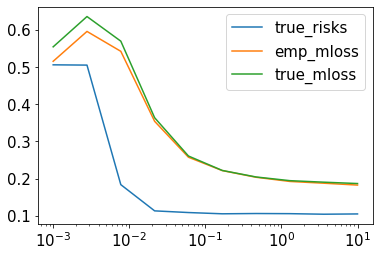

In [24]:
plt.plot(C_vals,true_risks, label='true_risks')
plt.plot(C_vals,emp_mloss, label='emp_mloss')
plt.plot(C_vals,true_mloss, label='true_mloss')

plt.xscale('log')
plt.legend()

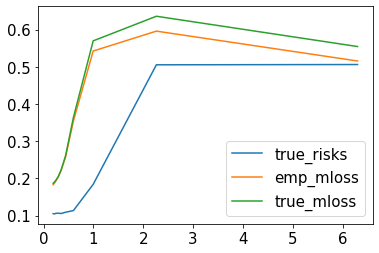

In [25]:
plt.plot(margins,true_risks, label='true_risks')
plt.plot(margins,emp_mloss, label='emp_mloss')
plt.plot(margins,true_mloss, label='true_mloss')

plt.legend()

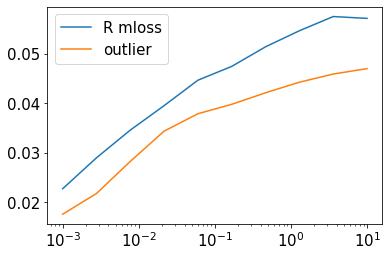

In [26]:
plt.plot(C_vals,rads, label='R mloss')
plt.plot(C_vals,outliers, label='outlier')

plt.xscale('log')
plt.legend()

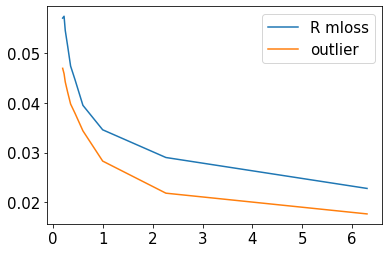

In [27]:
plt.plot(margins,rads, label='R mloss')
plt.plot(margins,outliers, label='outlier')

plt.legend()

## aggregate formulas

(1) True risk <

(2) true_mloss <

(3) emp_risk + outlier + sqrt(log(1/delta)/2m) <

(4) emp_risk + 2 * rad_mloss + sqrt(log(1/delta)/2m) <

(5) emp_risk + 2/rho * conf + sqrt(log(1/delta)/2m)

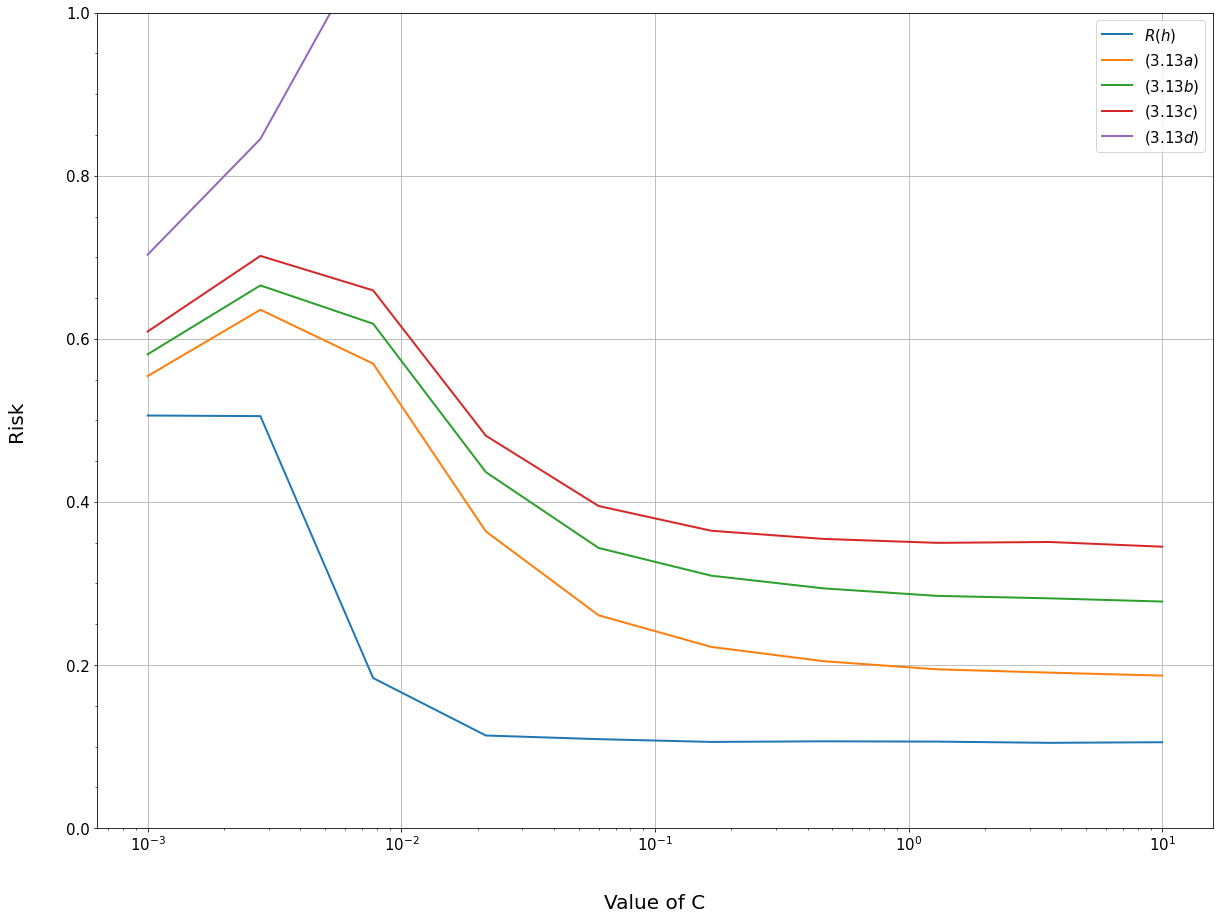

In [29]:
import matplotlib.cm as cm
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=[20,15])

color_val = 0.2
cmain = cm.Oranges(color_val)
csub = cm.Blues(color_val)

delta = 0.1

f1 = true_risks
f2 = true_mloss
f3 = np.array(emp_mloss) + np.array(outliers) + np.sqrt(np.log(1/delta)/(2*m))
f4 = np.array(emp_mloss) + 2 * np.array(rads) + np.sqrt(np.log(1/delta)/(2*m))
f5 = np.array(emp_mloss) + (2 / np.array(margins)) * np.array(confs) + np.sqrt(np.log(1/delta)/(2*m))

'''
plt.plot(C_vals, f1, lw=2, label=r'$R(h)$')
plt.plot(C_vals, f2, lw=2, label=r'$\mathbb{E}(\Phi_\rho(yh(x)))$')
plt.plot(C_vals, f3, lw=2, label=r'$\^{R}_{S,p}(h) + \mathbb{E}(\Phi(S)) + \sqrt{\frac{log\frac{1}{\delta}}{2m}}$')
plt.plot(C_vals, f4, lw=2, label=r'$\^{R}_{S,p}(h) + 2\mathfrak{R}_\mathfrak{m}(\Phi_\rho \circ \tilde{H}) + \sqrt{\frac{log\frac{1}{\delta}}{2m}} $')
plt.plot(C_vals, f5, lw=2, label=r'$\^{R}_{S,p}(h) + \frac{2}{\rho}\mathfrak{R}_\mathfrak{m}(H) + \sqrt{\frac{log\frac{1}{\delta}}{2m}} $')
'''

plt.plot(C_vals, f1, lw=2, label=r'$R(h)$')
plt.plot(C_vals, f2, lw=2, label=r'$(3.13a)$')
plt.plot(C_vals, f3, lw=2, label=r'$(3.13b)$')
plt.plot(C_vals, f4, lw=2, label=r'$(3.13c)$')
plt.plot(C_vals, f5, lw=2, label=r'$(3.13d)$')


plt.ylim(0,1)
plt.xscale('log')
#plt.xlim(-0.5,2.5)

ax.minorticks_on()
ax.grid(True, which='major')
#ax.xticks( C_vals )

ax.xaxis.set_major_locator(MultipleLocator(0.5))
#ax.yaxis.set_major_locator(MultipleLocator(0.1))

#ax.xaxis.set_minor_locator(AutoMinorLocator(0.5))
#ax.yaxis.set_minor_locator(AutoMinorLocator(0.05))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
#ax.grid(which='major', color='#CCCCCC', linestyle='--')
#ax.grid(which='minor', color='#CCCCCC', linestyle=':',lw=3)

plt.xticks([1e-3, 1e-2, 1e-1, 1e-0, 10], fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='upper right')

plt.xlabel("Value of C", fontsize=20, labelpad=40)
plt.ylabel("Risk", fontsize=20, labelpad=40)
#plt.title(r'Comparison of risk bounds', fontsize=20, pad=40)

plt.savefig("images/FINAL_VOICE_8_500_C.png", bbox_inches='tight')

plt.show()


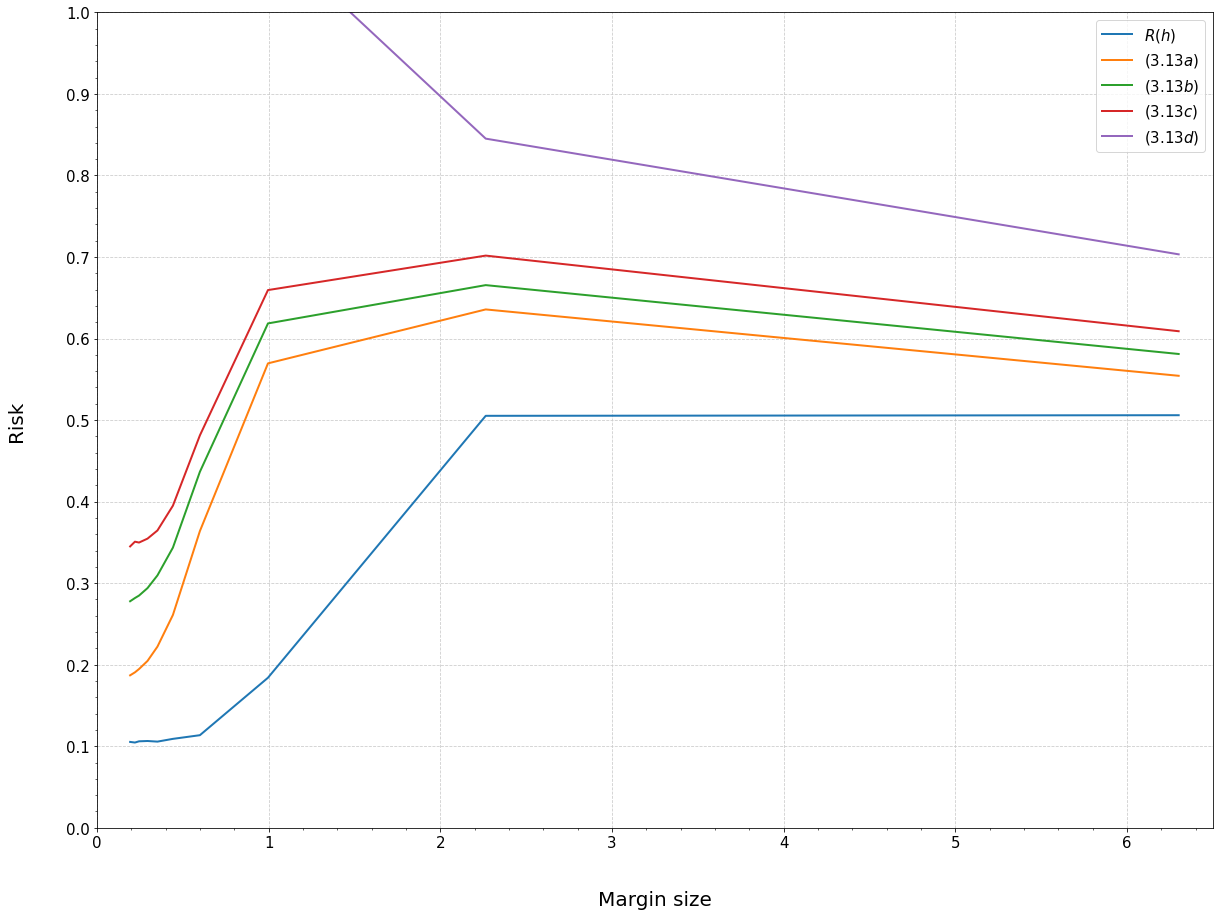

In [35]:
import matplotlib.cm as cm
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=[20,15])

color_val = 0.2
cmain = cm.Oranges(color_val)
csub = cm.Blues(color_val)

delta = 0.1

f1 = true_risks
f2 = true_mloss
f3 = np.array(emp_mloss) + np.array(outliers) + np.sqrt(np.log(1/delta)/(2*m))
f4 = np.array(emp_mloss) + 2 * np.array(rads) + np.sqrt(np.log(1/delta)/(2*m))
f5 = np.array(emp_mloss) + (2 / np.array(margins)) * np.array(confs) + np.sqrt(np.log(1/delta)/(2*m))

'''
plt.plot(margins, f1, lw=2, label=r'$R(h)$')
plt.plot(margins, f2, lw=2, label=r'$\mathbb{E}(\Phi_\rho(yh(x)))$')
plt.plot(margins, f3, lw=2, label=r'$\^{R}_{S,p}(h) + \mathbb{E}(\Phi(S)) + \sqrt{\frac{log\frac{1}{\delta}}{2m}}$')
plt.plot(margins, f4, lw=2, label=r'$\^{R}_{S,p}(h) + 2\mathfrak{R}_\mathfrak{m}(\Phi_\rho \circ \tilde{H}) + \sqrt{\frac{log\frac{1}{\delta}}{2m}} $')
plt.plot(margins, f5, lw=2, label=r'$\^{R}_{S,p}(h) + \frac{2}{\rho}\mathfrak{R}_\mathfrak{m}(H) + \sqrt{\frac{log\frac{1}{\delta}}{2m}} $')
'''

plt.plot(margins, f1, lw=2, label=r'$R(h)$')
plt.plot(margins, f2, lw=2, label=r'$(3.13a)$')
plt.plot(margins, f3, lw=2, label=r'$(3.13b)$')
plt.plot(margins, f4, lw=2, label=r'$(3.13c)$')
plt.plot(margins, f5, lw=2, label=r'$(3.13d)$')

plt.ylim(0,1)
#plt.xscale('log')
plt.xlim(0,6.5)

ax.minorticks_on()
ax.grid(True, which='major')
#ax.xticks( C_vals )

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

#ax.xaxis.set_minor_locator(AutoMinorLocator(0.5))
#ax.yaxis.set_minor_locator(AutoMinorLocator(0.05))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
#ax.grid(which='minor', color='#CCCCCC', linestyle=':',lw=3)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='upper right')

plt.xlabel("Margin size", fontsize=20, labelpad=40)
plt.ylabel("Risk", fontsize=20, labelpad=40)
#plt.title(r'Comparison of risk bounds', fontsize=20, pad=40)

plt.savefig("images/FINAL_VOICE_8_500_M.png", bbox_inches='tight')

plt.show()


In [33]:
for i in range(10):
    print("{:.4f}".format(C_vals[i]),
          "&", "{:.4f}".format(margins[i]),
          "&", "{:.4f}".format(true_risks[i]),
          "&", "{:.4f}".format(true_mloss[i]),
          "&", "{:.4f}".format(outliers[i]),
          "&", "{:.4f}".format(rads[i]),
          "&", "{:.4f}".format(confs[i]), "\\\\")

0.0010 & 6.3003 & 0.5060 & 0.5543 & 0.0176 & 0.0228 & 0.4405 \\
0.0028 & 2.2643 & 0.5052 & 0.6357 & 0.0218 & 0.0290 & 0.2281 \\
0.0077 & 0.9961 & 0.1840 & 0.5696 & 0.0283 & 0.0346 & 0.2511 \\
0.0215 & 0.5995 & 0.1136 & 0.3639 & 0.0344 & 0.0395 & 0.3668 \\
0.0599 & 0.4423 & 0.1091 & 0.2610 & 0.0379 & 0.0447 & 0.3373 \\
0.1668 & 0.3524 & 0.1057 & 0.2222 & 0.0398 & 0.0474 & 0.3337 \\
0.4642 & 0.2945 & 0.1064 & 0.2046 & 0.0421 & 0.0514 & 0.3283 \\
1.2915 & 0.2452 & 0.1061 & 0.1947 & 0.0443 & 0.0546 & 0.3946 \\
3.5938 & 0.2213 & 0.1046 & 0.1907 & 0.0459 & 0.0575 & 0.4533 \\
10.0000 & 0.1933 & 0.1053 & 0.1870 & 0.0470 & 0.0571 & 0.5118 \\
